In [1]:
# Distribution functions
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix

# Random Seed
np.random.seed(13)

In [4]:
def call_option_price(s0, M, t, v):
    
    d1=(-np.log(M)+(r+np.square(v)/2)*t)/(v*np.sqrt(t))
    d2=(-np.log(M)+(r-np.square(v)/2)*t)/(v*np.sqrt(t))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    return s0 * N_d1 - s0 * M * np.exp(-r*t) * N_d2

r = 0.02
s0 = 100.0
N = 10000

Ms = np.array((0.5+1.0*np.random.random(N)))
Vs = np.array(np.random.uniform(0.1, 0.5, N)) # add more randomness to the volatility
Vs2 =  Vs.copy()
Ts = np.array(np.random.random(N)) * 5.0
Ts2 =  Ts.copy()

Ps = np.array([call_option_price(s0, m, t, v) for m, t, v in zip(Ms,Ts,Vs)])

Y = Ps.copy()
X = np.concatenate([Ms.reshape(-1,1), Ts.reshape(-1,1),Vs.reshape(-1,1)],axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])

In [10]:
dataset_new = pd.DataFrame(dataset, columns=['Moneyness','Time','Volatility'])
Ms2=1/((1/Ms)+0.0001)
X_new = np.concatenate([Ms2.reshape(-1,1), Ts2.reshape(-1,1),Vs2.reshape(-1,1)],axis=1)
#X_new = scaler.transform(X_new)
Ps2 = np.array([call_option_price(s0, m, t, v) for m, t, v in zip(Ms2,Ts2,Vs2)])
dataset_new = pd.DataFrame(data=np.concatenate((Ps2.reshape(-1,1),X_new),axis=1), columns=['Price2','Moneyness2','Time2','Volatility2'])

In [11]:
dataset

,Price,Moneyness,Time,Volatility
0,53.817554,0.681128,4.410757,0.492518
1,8.114007,1.203360,1.077176,0.344062
2,29.418790,1.210696,4.151983,0.418039
3,27.052728,1.112547,2.387878,0.483261
4,0.010818,1.041176,0.018711,0.136188
...,...,...,...,...
9995,50.023647,0.514439,1.447082,0.140000
9996,25.271782,0.890363,4.651956,0.179299
9997,22.146168,1.101546,4.563288,0.265874
9998,10.665077,0.955468,1.500697,0.135610


In [12]:
dataset_new

,Price2,Moneyness2,Time2,Volatility2
0,53.819575,0.681082,4.410757,0.492518
1,8.117723,1.203215,1.077176,0.344062
2,29.422704,1.210550,4.151983,0.418039
3,27.056569,1.112424,2.387878,0.483261
4,0.010987,1.041068,0.018711,0.136188
...,...,...,...,...
9995,50.026217,0.514413,1.447082,0.140000
9996,25.276375,0.890283,4.651956,0.179299
9997,22.150427,1.101424,4.563288,0.265874
9998,10.670791,0.955377,1.500697,0.135610


In [8]:
def call_delta(M, t, v, q):
    # Black Scholes Equation
    d1=(-np.log(M)+(r+np.square(v)/2)*t)/(v*np.sqrt(t))
    N_d1 = norm.cdf(d1)
    return np.exp(-q*t) * N_d1

In [9]:
delta_BS = np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms,Ts,Vs)])

In [21]:
dataset['Price2'] = dataset_new['Price2']
dataset['Moneyness2'] = dataset_new['Moneyness2']
dataset['Time2'] = dataset_new['Time2']
dataset['Volatility2'] = dataset_new['Volatility2']
dataset['DeltaBS'] = delta_BS.reshape(-1,1)
dataset
dataset['DeltaEst'] = (dataset['Price2']-dataset['Price'])/0.01

In [22]:
dataset

,Price,Moneyness,Time,Volatility,Price2,Moneyness2,Time2,Volatility2,DeltaBS,DeltaEst
0,53.817554,0.681128,4.410757,0.492518,53.819575,0.681082,4.410757,0.492518,0.834901,0.202100
1,8.114007,1.203360,1.077176,0.344062,8.117723,1.203215,1.077176,0.344062,0.389921,0.371607
2,29.418790,1.210696,4.151983,0.418039,29.422704,1.210550,4.151983,0.418039,0.617505,0.391425
3,27.052728,1.112547,2.387878,0.483261,27.056569,1.112424,2.387878,0.483261,0.615820,0.384143
4,0.010818,1.041176,0.018711,0.136188,0.010987,1.041068,0.018711,0.136188,0.016313,0.016989
...,...,...,...,...,...,...,...,...,...,...
9995,50.023647,0.514439,1.447082,0.140000,50.026217,0.514413,1.447082,0.140000,0.999987,0.257078
9996,25.271782,0.890363,4.651956,0.179299,25.276375,0.890283,4.651956,0.179299,0.768596,0.459309
9997,22.146168,1.101546,4.563288,0.265874,22.150427,1.101424,4.563288,0.265874,0.608105,0.425900
9998,10.665077,0.955468,1.500697,0.135610,10.670791,0.955377,1.500697,0.135610,0.704693,0.571450


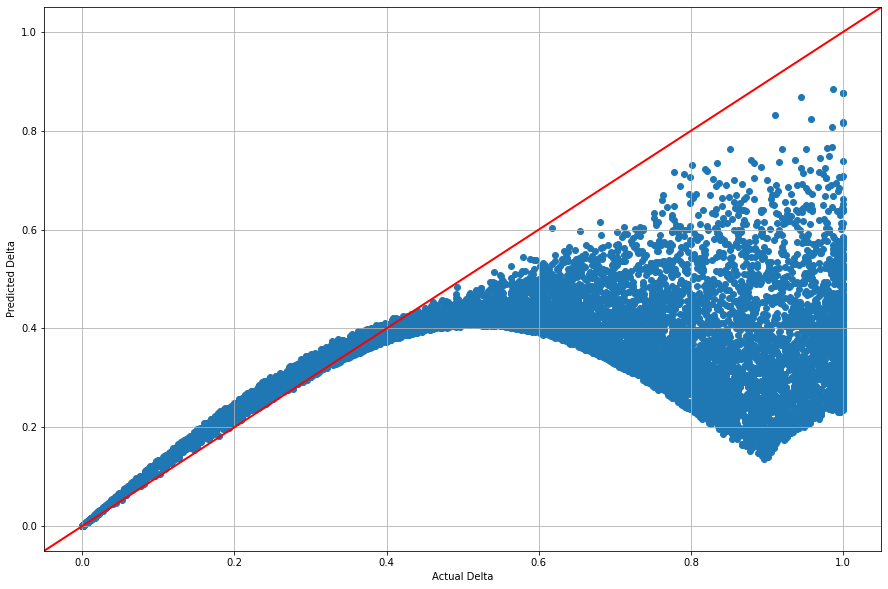

In [23]:
plt.figure(figsize = (15,10))
plt.scatter(dataset['DeltaBS'],dataset['DeltaEst'])
plt.xlabel("Actual Delta")
plt.ylabel("Predicted Delta")
plt.axline((0,0), (1, 1), linewidth=2, color='r')
plt.grid(True)